(heavy_tail)=
# 重尾分布

除了Anaconda中的内容，本讲还需要以下库：

In [1]:
!pip install --upgrade yfinance pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.0 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 103.3 MB/s eta 0:00:00


  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... - done


  Preparing metadata (pyproject.toml) ... -

 done


 \

 |

 done
  Created wheel for peewee: filename=peewee-3.17.9-cp312-cp312-linux_x86_64.whl size=303841 sha256=47e92665834ddac77cdd4f5f51cf0214e3f61cae256d07fa633aed0148e96a97
  Stored in directory: /home/runner/.cache/pip/wheels/43/ef/2d/2c51d496bf084945ffdf838b4cc8767b8ba1cc20eb41588831
Successfully built peewee


我们使用以下的导入。

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm

from pandas_datareader import wb
from scipy.stats import norm, cauchy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

## 概览

重尾分布是一类能产生“极端”结果的分布。

在自然科学（以及更多传统的经济学课程）中，重尾分布常被视为相当异乎寻常和非标准的。

然而，事实证明，重尾分布在经济学中扮演着至关重要的角色。

实际上，经济学中许多 -- 如果不是大部分 -- 重要的分布都是重尾的。

在这次讲座中，我们将解释什么是重尾，以及为什么它们是 -- 或者至少应该是 -- 经济分析的核心。


### 引言：轻尾分布

大多数{doc}`常用概率分布<prob_dist>`在经典统计学和自然科学中都具有“轻尾”。

为了解释这个概念，让我们先看一些例子。

```{prf:example}
:label: ht_ex_nd

经典的例子是[正态分布](https://en.wikipedia.org/wiki/Normal_distribution)，其密度公式为

$$ 
f(x) = \frac{1}{\sqrt{2\pi}\sigma} 
\exp\left( -\frac{(x-\mu)^2}{2 \sigma^2} \right)
\qquad
(-\infty < x < \infty)
$$

这里的两个参数 $\mu$ 和 $\sigma$ 分别代表均值和标准差。

随着 $x$ 从 $\mu$ 偏离，$f(x)$ 的值会非常快地趋向于零。
```

我们可以通过绘制密度图和展示观测值的直方图来看到这一点，如下代码所示（假设 $\mu=0$ 和 $\sigma=1$）。

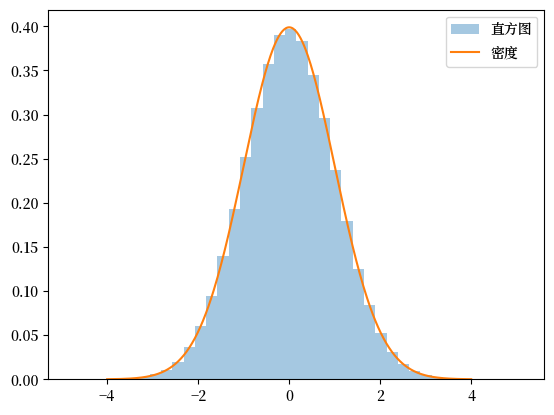

In [3]:
fig, ax = plt.subplots()
X = norm.rvs(size=1_000_000)
ax.hist(X, bins=40, alpha=0.4, label='直方图', density=True)
x_grid = np.linspace(-4, 4, 400)
ax.plot(x_grid, norm.pdf(x_grid), label='密度')
ax.legend()
plt.show()

请注意：

* 密度的尾部在两个方向上迅速趋于零
* 即使是1,000,000次抽样，我们也没有观察到非常大或非常小的值。

我们可以通过执行以下代码更清楚地看到最后一点：

In [4]:
X.min(), X.max()

(-4.796677585930489, 5.112138257149344)

这里是从同一分布中抽取的另一种视图：

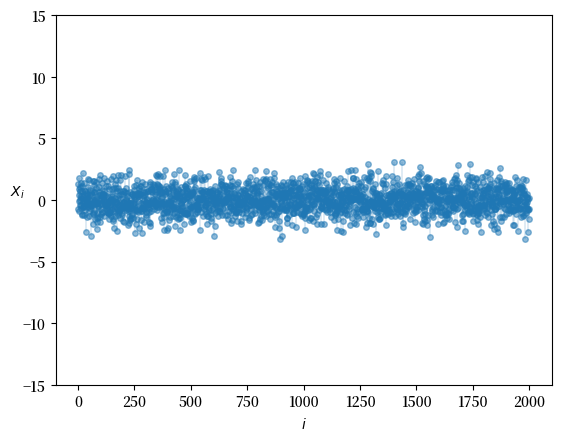

In [5]:
n = 2000
fig, ax = plt.subplots()
data = norm.rvs(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_ylim(-15, 15)
ax.set_xlabel('$i$')
ax.set_ylabel('$X_i$', rotation=0)
plt.show()

我们已经绘制了每个单独的抽样 $X_i$ 与 $i$ 的对应关系。

没有一个非常大或非常小。

换句话说，极端的观测值很少，抽样倾向于不会太偏离均值。

换种说法，轻尾分布是那些很少产生极端值的分布。

（更正式的定义见{ref}`下面 <heavy-tail:formal-definition>`。）

许多统计学家和计量经济学家使用经验法则，如“结果超出均值四到五个标准差可以安全忽略。”

但这只有在分布具有轻尾的时候才成立。

### 何时适用于轻尾分布？

在概率理论和现实世界中，许多分布都是轻尾的。

例如，人类身高就是轻尾分布。

是的，我们确实看到了一些非常高的人。

* 例如，篮球运动员[孙明明](https://en.wikipedia.org/wiki/Sun_Mingming)身高2.32米

但是你有没有听说过有人身高达20米、200米或2000米的吗？

你有没有想过为什么没有？

毕竟，全世界有80亿人！

本质上，我们看不到这样的数据是因为人类身高的分布具有非常轻的尾部。

事实上，人类身高的分布符合类似正态分布的钟形曲线。

### 资产回报

但经济数据呢？

我们首先来看一些金融数据。

我们的目标是绘制自2015年1月1日至2022年7月1日期间亚马逊（AMZN）股价的每日变化。

如果我们不考虑股息，这相当于每日回报。

以下代码通过 `yfinance` 库使用雅虎财经数据生成所需的图表。

In [6]:
data = yf.download('AMZN', '2015-1-1', '2022-7-1', auto_adjust=False)

[*********************100%***********************]  1 of 1 completed

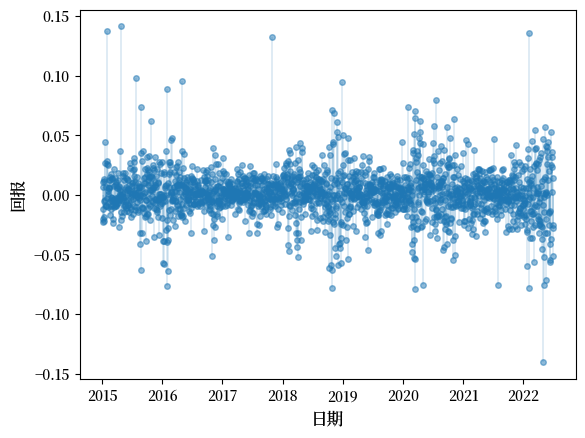

In [7]:
s = data['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('回报', fontsize=12)
ax.set_xlabel('日期', fontsize=12)

plt.show()

这些数据看起来与我们上面看到的正态分布的抽样有所不同。

有几个观测值非常极端。

如果我们查看其他资产，比如比特币，我们会得到类似的图像。

In [8]:
data = yf.download('BTC-USD', '2015-1-1', '2022-7-1', auto_adjust=False)

[*********************100%***********************]  1 of 1 completed

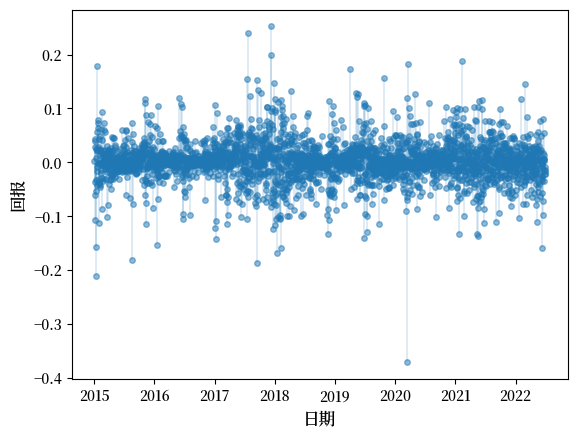

In [9]:
s = data['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('回报', fontsize=12)
ax.set_xlabel('日期', fontsize=12)

plt.show()

这个直方图也与正态分布的直方图不同:

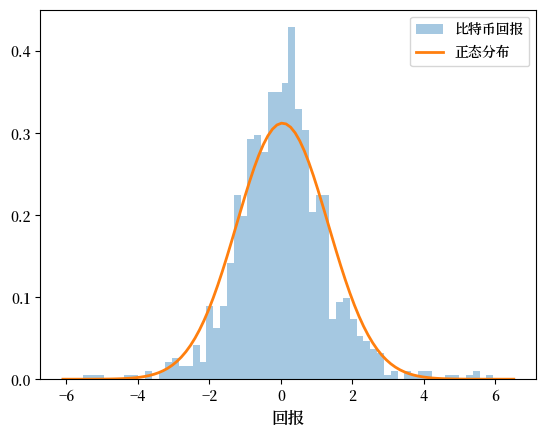

In [10]:
r = np.random.standard_t(df=5, size=1000)

fig, ax = plt.subplots()
ax.hist(r, bins=60, alpha=0.4, label='比特币回报', density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(r), np.std(r))
ax.plot(x, p, linewidth=2, label='正态分布')

ax.set_xlabel('回报', fontsize=12)
ax.legend()

plt.show()

如果我们查看更高频率的回报数据（例如，逐笔交易），我们经常会看到更极端的观测。

例如，参见 {cite}`mandelbrot1963variation` 或 {cite}`rachev2003handbook`。

### 其他数据

我们刚刚看到的数据被称为“重尾”。

在重尾分布中，极端结果相对频繁地发生。

```{prf:example}
:label: ht_ex_od

重要的是，在经济和金融环境中观察到了许多重尾分布的例子！

例如，收入和财富分布是重尾的

* 你可以想象这样的情景：大多数人的财富较低或适中，但有些人非常富有。

公司规模分布也是重尾的

* 你也可以想象这样的情景：大多数公司都很小，但有些公司非常庞大。

城镇和城市大小的分布是重尾的

* 大多数城镇和城市都很小，但有些非常大。
```

在本讲座的后面部分，我们将研究这些分布中的重尾现象。

### 为什么我们应该关心？

重尾在经济数据中很常见，但这是否意味着它们很重要？

对这个问题的回答是肯定的！

当分布是重尾的，我们需要仔细考虑一些问题，如

* 多样化和风险
* 预测
* 税收（针对重尾收入分布），等等。

我们将回到这些点 {ref}`下面 <heavy-tail:application>`。

## 视觉比较
在本节中，我们将介绍帕雷托分布、计数器累积分布函数和幂律等重要概念，这些概念有助于识别重尾分布。

稍后我们将提供有关轻尾和重尾差异的数学定义。

但现在让我们先进行一些视觉比较，以帮助我们建立对这两种类型分布差异的直觉。

### 模拟

下图显示了一次模拟。

上面两个子图各显示来自正态分布的120个独立抽取，这是轻尾分布。

下面的子图显示来自[柯西分布](https://en.wikipedia.org/wiki/Cauchy_distribution)的120个独立抽取，这是重尾分布。

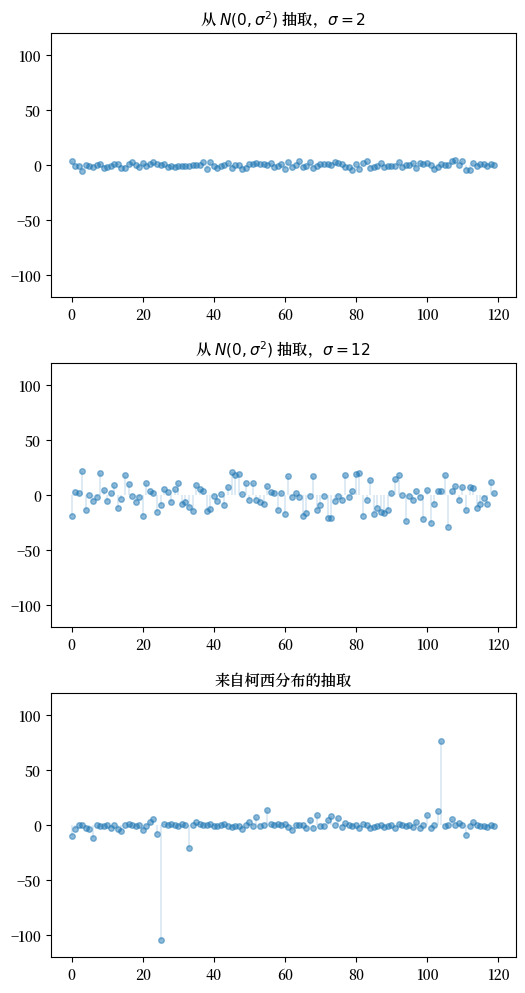

In [11]:
n = 120
np.random.seed(11)

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

for ax in axes:
    ax.set_ylim((-120, 120))

s_vals = 2, 12

for ax, s in zip(axes[:2], s_vals):
    data = np.random.randn(n) * s
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(fr"从 $N(0, \sigma^2)$ 抽取，$\sigma = {s}$", fontsize=11)

ax = axes[2]
distribution = cauchy()
data = distribution.rvs(n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_title(f"来自柯西分布的抽取", fontsize=11)

plt.subplots_adjust(hspace=0.25)

plt.show()

在顶部的子图中，正态分布的标准偏差为2，抽取值围绕均值聚集。

在中间的子图中，标准偏差增加到12，如预期的那样，分散度增加。

底部的子图中，柯西的抽取显示出一种不同的模式：大多数观察值紧密围绕均值聚集，但偶有几个从均值突然大偏差。

这是典型的重尾分布特征。


### 非负分布

让我们比较一些只取非负值的分布。

其中一种是指数分布，我们在{doc}`our lecture on probability and distributions <prob_dist>`中讨论过。

指数分布是一种轻尾分布。

这里有一些来自指数分布的抽样。

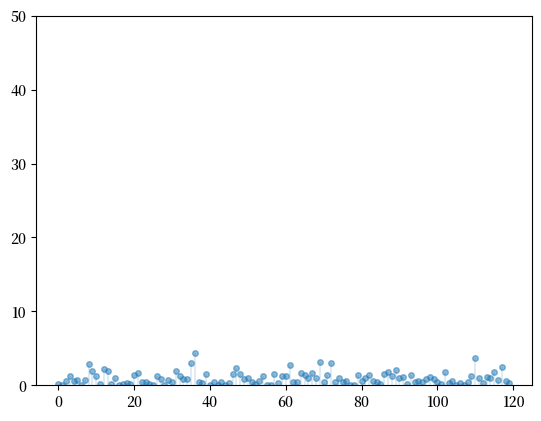

In [12]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 50))

data = np.random.exponential(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)

plt.show()

另一个非负分布是[帕累托分布](https://en.wikipedia.org/wiki/Pareto_distribution)。

如果 $X$ 遵循帕累托分布，那么存在正常数 $x$ 和 $\alpha$，使得

```{math}
:label: pareto

\mathbb P\{X > x\} =
\begin{cases}
    \left( \frac{\bar x}{x} \right)^{\alpha}
        & \text{ 如果 } x \geq \bar x
    \\
    1
        & \text{ 如果 } x < \bar x
\end{cases}
```

参数 $\alpha$ 被称为**尾指数**，$\bar x$ 被称为**最小值**。

帕累托分布是一个重尾分布。

帕累托分布产生的一个方式是指数随机变量的指数。

特别地，如果 $X$ 是以率参数 $\alpha$ 指数分布的，那么

$$
Y = \bar x \exp(X) 
$$

具有最小值 $\bar x$ 和尾指数 $\alpha$ 的帕累托分布。

这里是一些从帕累托分布中抽取的数据，尾指数为 $1$，最小值为 $1$。

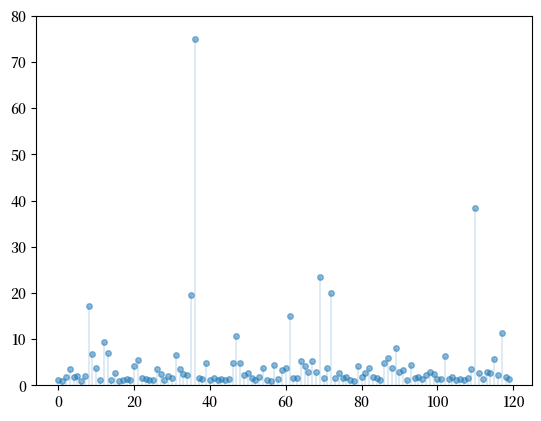

In [13]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 80))
exponential_data = np.random.exponential(size=n)
pareto_data = np.exp(exponential_data)
ax.plot(list(range(n)), pareto_data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, pareto_data, lw=0.2)

plt.show()

注意极端结果更常见。

### 对立累积分布函数

对于非负随机变量，视觉上区分轻尾和重尾的一种方法是查看**对立累积分布函数**（CCDF）。

对于一个具有CDF $F$ 的随机变量 $X$，CCDF定义为函数

$$
G(x) := 1 - F(x) = \mathbb P\{X > x\}
$$

（有些作者称$G$为“生存”函数。）

CCDF显示随着 $x \to \infty$，上尾速度减少到零的快慢。

如果$X$是具有速率参数$\alpha$的指数分布，则其CCDF为

$$
G_E(x) = \exp(- \alpha x)
$$

随着 $x$ 增大，这个函数相对快速地趋于零。

标准帕雷托分布，其中 $\beta x = 1$，具有CCDF

$$
G_P(x) = x^{- \alpha}
$$

这个函数在 $x \to \infty$ 时趋于零，但比 $G_E$ 更慢。

```{exercise}
:label: ht_ex_x1

展示如何从指数分布的CCDF推导出标准帕雷托分布的CCDF。
```

```{solution-start} ht_ex_x1
:class: dropdown
```
设 $G_E$ 和 $G_P$ 如上定义，设 $X$ 是具有速率参数 $\alpha$ 的指数分布，并设 $Y = \exp(X)$，我们有

$$
\begin{aligned}
 G_P(y) & = \mathbb P\{Y > y\} \\
         & = \mathbb P\{\exp(X) > y\} \\
         & = \mathbb P\{X > \ln y\} \\
         & = G_E(\ln y) \\
         & = \exp(- \alpha \ln y) \\
        & = y^{-\alpha}
\end{aligned}
$$
```{solution-end}
```

这是一个图示，展示了$G_E$比$G_P$衰减得更快。

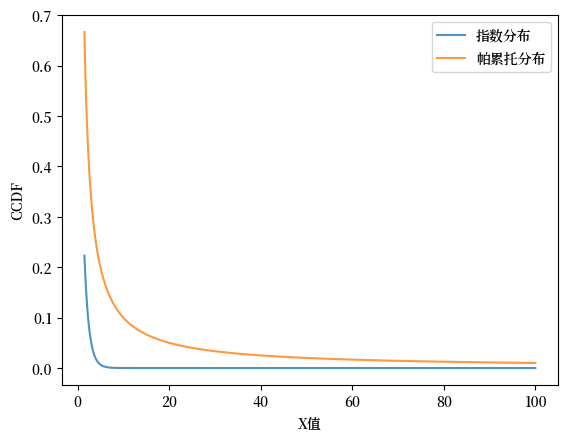

In [14]:
x = np.linspace(1.5, 100, 1000)
fig, ax = plt.subplots()
alpha = 1.0
ax.plot(x, np.exp(- alpha * x), label='指数分布', alpha=0.8)
ax.plot(x, x**(- alpha), label='帕累托分布', alpha=0.8)
ax.set_xlabel('X值')
ax.set_ylabel('CCDF')
ax.legend()
plt.show()

下面是同一函数的对数对数图，便于视觉比较。

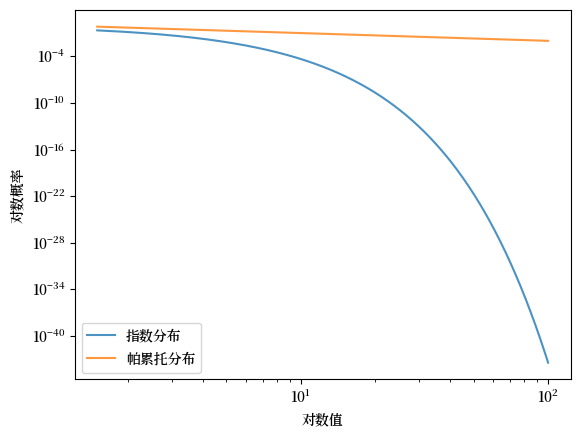

In [15]:
fig, ax = plt.subplots()
alpha = 1.0
ax.loglog(x, np.exp(- alpha * x), label='指数分布', alpha=0.8)
ax.loglog(x, x**(- alpha), label='帕累托分布', alpha=0.8)
ax.set_xlabel('对数值')
ax.set_ylabel('对数概率')
ax.legend()
plt.show()

在对数对数图中，帕累托的互补累积分布函数是线性的，而指数的则是凹的。

这个观点常用于在视觉化中区分轻尾分布和重尾分布——我们下面会再次讨论这一点。

### 实验 CCDFs

样本对应的 CCDF 函数是**经验 CCDF**。

给定一个样本 $x_1, \ldots, x_n$，经验 CCDF 定义为

$$
\hat G(x) = \frac{1}{n} \sum_{i=1}^n \mathbb 1\{x_i > x\}
$$

因此，$\hat G(x)$ 显示样本中超过 $x$ 的比例。

In [16]:
def eccdf(x, data):
    "简单的经验 CCDF 函数。"
    return np.mean(data > x)

下面是一些从模拟数据得到的经验 CCDFs 的图。

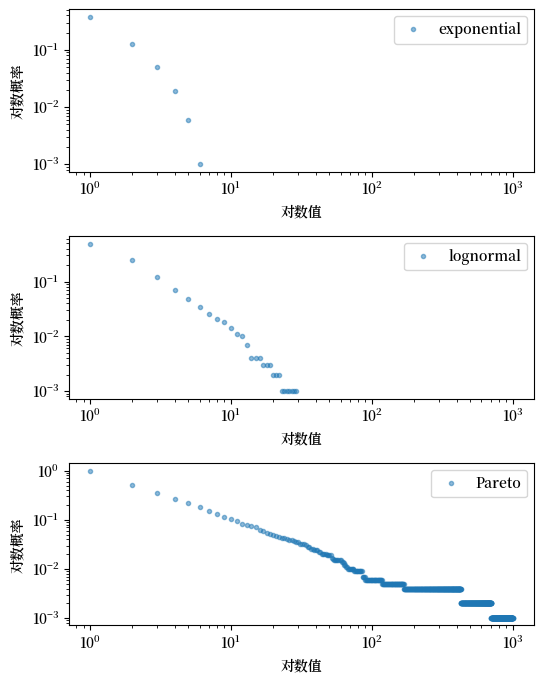

In [17]:
# 参数和网格
x_grid = np.linspace(1, 1000, 1000)
sample_size = 1000
np.random.seed(13)
z = np.random.randn(sample_size)

# Draws
data_exp = np.random.exponential(size=sample_size)
data_logn = np.exp(z)
data_pareto = np.exp(np.random.exponential(size=sample_size))

data_list = [data_exp, data_logn, data_pareto]

# 构建图形
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes = axes.flatten()
labels = ['exponential', 'lognormal', 'Pareto']

for data, label, ax in zip(data_list, labels, axes):

    ax.loglog(x_grid, [eccdf(x, data) for x in x_grid], 
        'o', markersize=3.0, alpha=0.5, label=label)
    ax.set_xlabel("对数值")
    ax.set_ylabel("对数概率")
    
    ax.legend()
    
    
fig.subplots_adjust(hspace=0.4)

plt.show()

与 CCDF 一样，帕累托分布的经验 CCDF 在对数-对数图中大致呈线性。

我们将在下面使用这个想法 [here](https://intro.quantecon.org/heavy_tails.html#heavy-tails-in-economic-cross-sections) 当我们查看真实数据时。

#### Q-Q图

我们也可以使用[qq图](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)来可视化比较两个概率分布。

[statsmodels](https://www.statsmodels.org/stable/index.html)包提供了一个方便的[qqplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html)函数，该函数默认将样本数据与正态分布的分位数进行比较。

如果数据来自正态分布，该图看起来会像：

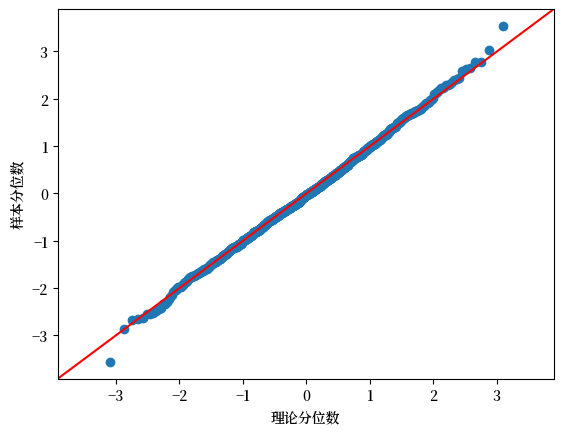

In [18]:
data_normal = np.random.normal(size=sample_size)
sm.qqplot(data_normal, line='45')
plt.xlabel("理论分位数")
plt.ylabel("样本分位数")
plt.show()

我们现在可以将其与指数分布、对数正态分布和帕累托分布进行比较

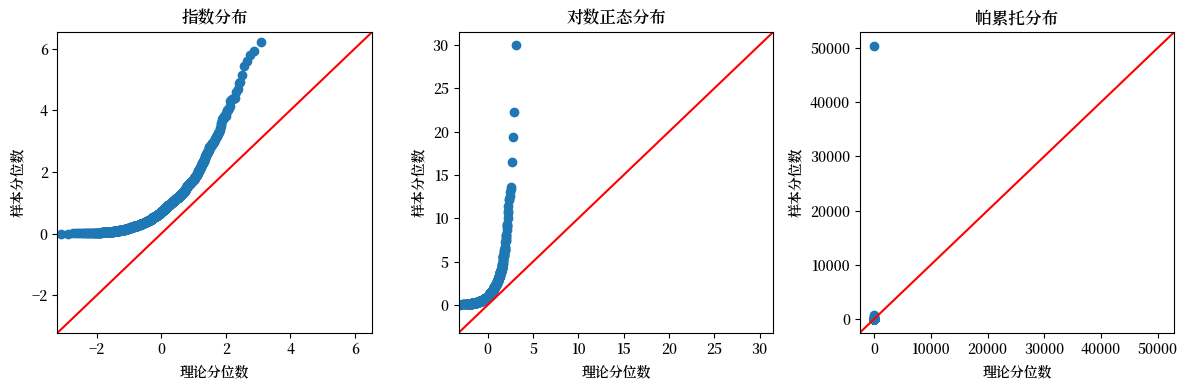

In [19]:
# 构建图形
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()
labels = ['指数分布', '对数正态分布', '帕累托分布']
for data, label, ax in zip(data_list, labels, axes):
    sm.qqplot(data, line='45', ax=ax)
    ax.set_title(label)
    ax.set_xlabel('理论分位数')
    ax.set_ylabel('样本分位数')
plt.tight_layout()
plt.show()

### 幂律

在经济和社会现象中，一类特定的重尾分布被反复发现：所谓的幂律。

若随机变量 $X$ 满足**幂律**，则存在某个 $\alpha > 0$，

```{math}
\mathbb P\{X > x\} \approx  x^{-\alpha}
\quad \text{当 $x$ 很大}
```
我们可以更数学化地写成

```{math}
:label: plrt

\lim_{x \to \infty} x^\alpha \, \mathbb P\{X > x\} = c
\quad \text{对某个 $c > 0$}
```

通常说随机变量 $X$ 有这样的性质，
具有**帕累托尾**和**尾指数** $\alpha$。

注意，每个具有尾指数 $\alpha$ 的帕累托分布
都具有**帕累托尾**和**尾指数** $\alpha$。

我们可以将幂律视为帕累托分布的一种概括。

这些分布在它们的右上尾部类似于帕累托分布。

另一种考虑幂律的方式是将其视为一组分布，具有特定类型的（非常）重尾。

## 经济横截面中的重尾现象

如上所述，重尾在经济数据中非常普遍。

实际上，幂律分布似乎也十分常见。

我们现在通过展示重尾的经验互补累积分布函数（CCDF）来说明这一点。

所有的图都是以对数-对数坐标绘制的，因此幂律在对数-对数图中表现为直线，至少在上尾部分是这样。

我们隐藏了生成图形的代码，该代码有些复杂，但读者当然可以探索代码（也许可以在查看图形后进行）。

In [20]:
def empirical_ccdf(data, 
                   ax, 
                   aw=None,   # 权重
                   label=None,
                   xlabel=None,
                   add_reg_line=False, 
                   title=None):
    """
    接受数据向量并返回用于绘图的概率值。
    升级版的 empirical_ccdf
    """
    y_vals = np.empty_like(data, dtype='float64')
    p_vals = np.empty_like(data, dtype='float64')
    n = len(data)
    if aw is None:
        for i, d in enumerate(data):
            # 记录样本中大于 d 的分数
            y_vals[i] = np.sum(data >= d) / n
            p_vals[i] = np.sum(data == d) / n
    else:
        fw = np.empty_like(aw, dtype='float64')
        for i, a in enumerate(aw):
            fw[i] = a / np.sum(aw)
        pdf = lambda x: np.interp(x, data, fw)
        data = np.sort(data)
        j = 0
        for i, d in enumerate(data):
            j += pdf(d)
            y_vals[i] = 1- j

    x, y = np.log(data), np.log(y_vals)
    
    results = sm.OLS(y, sm.add_constant(x)).fit()
    b, a = results.params
    
    kwargs = [('alpha', 0.3)]
    if label:
        kwargs.append(('label', label))
    kwargs = dict(kwargs)

    ax.scatter(x, y, **kwargs)
    if add_reg_line:
        ax.plot(x, x * a + b, 'k-', alpha=0.6, label=f"斜率 = ${a: 1.2f}$")
    if not xlabel:
        xlabel='对数值'
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("对数概率", fontsize=12)
        
    if label:
        ax.legend(loc='lower left', fontsize=12)
        
    if title:
        ax.set_title(title)
        
    return np.log(data), y_vals, p_vals

In [21]:
def extract_wb(varlist=['NY.GDP.MKTP.CD'], 
               c='all_countries', 
               s=1900, 
               e=2021, 
               varnames=None):
    if c == "all_countries":
        # 仅保留国家（不包括汇总区域）
        countries = wb.get_countries()
        countries_name = countries[countries['region'] != 'Aggregates']['name'].values
        c = "all"
    
    df = wb.download(indicator=varlist, country=c, start=s, end=e).stack().unstack(0).reset_index()
    df = df.drop(['level_1'], axis=1).transpose()
    if varnames is not None:
        df.columns = varnames
        df = df[1:]
    
    df1 =df[df.index.isin(countries_name)]
    return df1

### 公司规模

以下是2020年来自福布斯全球2000强的最大500家公司的公司规模分布图。

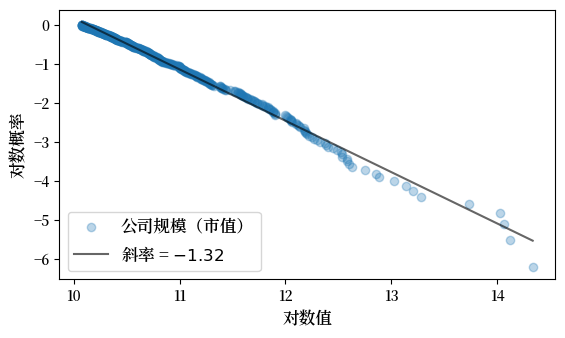

In [22]:
df_fs = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/forbes-global2000.csv')
df_fs = df_fs[['Country', 'Sales', 'Profits', 'Assets', 'Market Value']]
fig, ax = plt.subplots(figsize=(6.4, 3.5))

label="公司规模（市值）"
top = 500 # 设置排名前500的切断点
d = df_fs.sort_values('Market Value', ascending=False)
empirical_ccdf(np.asarray(d['Market Value'])[:top], ax, label=label, add_reg_line=True)

plt.show()

### 城市规模

以下是2023年来自世界人口审查的美国和巴西城市规模分布图。

大小由人口衡量。

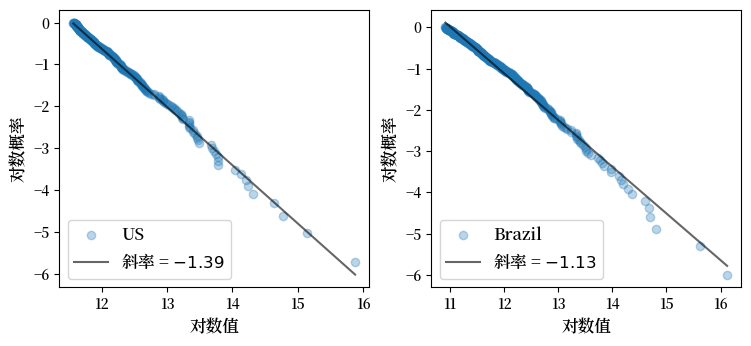

In [23]:
# 导入2023年美国和2023年巴西城市的人口数据
df_cs_us = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/cities_us.csv')
df_cs_br = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/cities_brazil.csv')

fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))

empirical_ccdf(np.asarray(df_cs_us["pop2023"]), axes[0], label="US", add_reg_line=True)
empirical_ccdf(np.asarray(df_cs_br['pop2023']), axes[1], label="Brazil", add_reg_line=True)

plt.show()

### 财富

这里是财富分布上尾部（前500名）的图表示。

数据来源于2020年的《福布斯亿万富翁》名单。

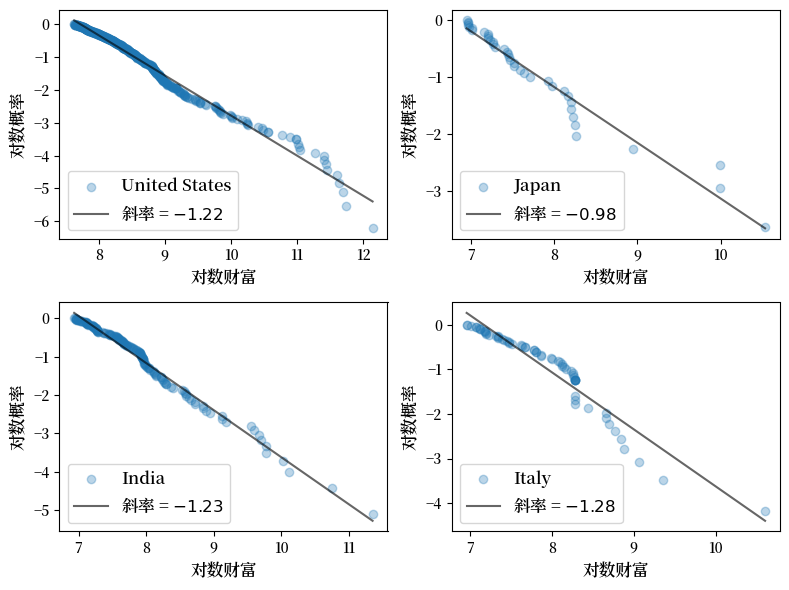

In [24]:
df_w = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/forbes-billionaires.csv')
df_w = df_w[['country', 'realTimeWorth', 'realTimeRank']].dropna()
df_w = df_w.astype({'realTimeRank': int})
df_w = df_w.sort_values('realTimeRank', ascending=True).copy()
countries = ['United States', 'Japan', 'India', 'Italy']  
N = len(countries)

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

for i, c in enumerate(countries):
    df_w_c = df_w[df_w['country'] == c].reset_index()
    z = np.asarray(df_w_c['realTimeWorth'])
    # 打印来自该国的全球前2000位富豪的人数
    top = 500           # 截止数：前500名
    if len(z) <= top:    
        z = z[:top]

    empirical_ccdf(z[:top], axs[i], label=c, xlabel='对数财富', add_reg_line=True)
    
fig.tight_layout()

plt.show()

### GDP

当然，并非所有的横截面分布都是重尾的。

这里我们展示的是各国人均GDP。

In [25]:
# 获取2021年所有地区和国家的GDP及人均GDP

variable_code = ['NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']
variable_names = ['GDP', '人均GDP']

df_gdp1 = extract_wb(varlist=variable_code, 
                     c="all_countries", 
                     s="2021", 
                     e="2021", 
                     varnames=variable_names)
df_gdp1.dropna(inplace=True)

/tmp/ipykernel_6275/140199782.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=varlist, country=c, start=s, end=e).stack().unstack(0).reset_index()


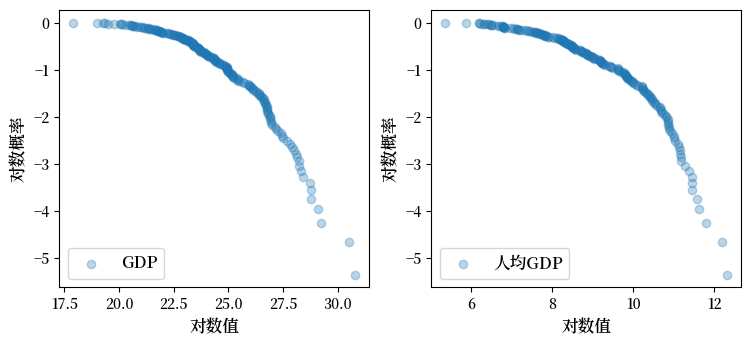

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))

for name, ax in zip(variable_names, axes):
    empirical_ccdf(np.asarray(df_gdp1[name]).astype("float64"), ax, add_reg_line=False, label=name)

plt.show()

图形是凹形的而不是线形的，因此分布具有轻尾。

这其中一个原因是这是关于一个综合变量的数据，其定义中涉及了一些平均处理。

平均处理往往会消除极端结果。


## 大数定律的失败

重尾分布的一个影响是样本平均值可能是底层均值的糟糕估计。

为了更好地理解这一点，请回想一下{doc}`我们早期关于大数定律的讨论<lln_clt>`，它考虑了具有共同分布$F$的独立同分布的$X_1, \ldots, X_n$

如果$\mathbb E |X_i|$是有限的，那么样本平均值$\bar X_n := \frac{1}{n} \sum_{i=1}^n X_i$满足

```{math}
:label: lln_as2

\mathbb P \left\{ \bar X_n \to \mu \text{ as } n \to \infty \right\} = 1
```

其中$\mu := \mathbb E X_i = \int x F(dx)$是样本的共同均值。

在大多数情况下，条件$\mathbb E | X_i | = \int |x| F(dx) < \infty$成立，但如果分布$F$是非常重尾的，则可能不成立。

例如，柯西分布就是不成立的。

让我们来看看这种情况下样本平均值的行为，看是否大数定律仍然有效。

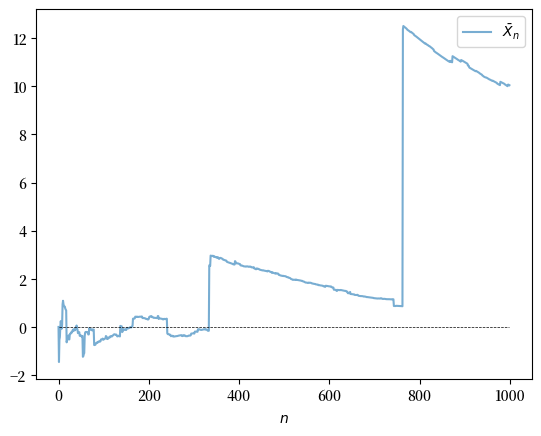

In [27]:
from scipy.stats import cauchy

np.random.seed(1234)
N = 1_000

distribution = cauchy()

fig, ax = plt.subplots()
data = distribution.rvs(N)

# 计算每个n的样本平均值
sample_mean = np.empty(N)
for n in range(1, N):
    sample_mean[n] = np.mean(data[:n])

# 绘图
ax.plot(range(N), sample_mean, alpha=0.6, label='$\\bar{X}_n$')
ax.plot(range(N), np.zeros(N), 'k--', lw=0.5)
ax.set_xlabel(r"$n$")
ax.legend()

plt.show()

序列显示没有收敛的迹象。

我们在练习中会回到这一点。


(heavy-tail:application)=
## 为什么重尾分布很重要？

我们已经看到

1. 在经济学中，重尾分布非常常见；
2. 当尾部非常重时，大数定律失效。

但是在现实世界中，重尾分布重要吗？让我们简要讨论一下它们为什么重要。

### 分散化投资

投资中一个最重要的概念是使用分散化来降低风险。

这是一个非常古老的想法——例如，考虑这个表达式“不要把所有的鸡蛋放在一个篮子里”。

为了说明这一点，设想一个拥有一美元财富的投资者，在$n$种资产中进行选择，这些资产的回报为$X_1, \ldots, X_n$。

假设不同资产的回报是独立的，每个回报有均值$\mu$和方差$\sigma^2$。

如果投资者将所有财富投资在一个资产上，那么该投资组合的预期收益为$\mu$，方差为$\sigma^2$。

如果投资者将她的财富均分到每一个资产上，即每个资产的份额为$1/n$，那么投资组合的收益为

$$
Y_n = \sum_{i=1}^n \frac{X_i}{n} = \frac{1}{n} \sum_{i=1}^n X_i.
$$

试着计算均值和方差。

你会发现：

* 均值保持不变，依旧是$\mu$，
* 投资组合的方差降低到了$\sigma^2 / n$。

正如预期的那样，分散化减少了风险。

但是这里有一个隐藏的假设：回报的方差是有限的。

如果分布是重尾的并且方差是无限的，那么这种逻辑就是不正确的。

例如，我们上面看到，如果每个$X_i$都是柯西分布，那么$Y_n$也是。

这意味着分散化根本没有帮助！

### 财政政策

财富分配中尾部的厚重程度对税收和再分配政策至关重要。

收入分配也是如此。

例如，收入分配尾部的厚重程度有助于决定{doc}`税收政策 <mle>`。

(cltail)=
## 分类尾部特性

到目前为止，我们讨论了轻尾和重尾，但没有任何数学定义。

现在让我们来纠正这一点。

我们将关注非负随机变量及其分布的右侧尾部。

左侧尾部的定义非常相似，为了简化论述，我们省略它们。

(heavy-tail:formal-definition)=
### 轻尾和重尾

一个在 $\mathbb R_+$ 上有密度 $f$ 的分布 $F$ 被称为[重尾](https://en.wikipedia.org/wiki/Heavy-tailed_distribution)的，如果

```{math}
:label: defht

\int_0^\infty \exp(tx) f(x) dx = \infty \; \text{ 对于所有 } t > 0.
```

我们说一个非负随机变量 $X$ 是**重尾**的，如果它的密度是重尾的。

这等同于说它的**矩生成函数** $m(t) := \mathbb E \exp(t X)$ 对于所有 $t > 0$ 都是无限的。

例如，[对数正态分布](https://en.wikipedia.org/wiki/Log-normal_distribution)是重尾的，因为它的矩生成函数在 $(0, \infty)$ 上无限。


帕累托分布也是重尾分布。

非正式地说，重尾分布是指不受指数型界限约束的分布（即尾部比指数分布更重）。

如果一个在 $\mathbb R_+$ 上的分布 $F$ 不是重尾的，则称它为**轻尾**。

一个非负随机变量 $X$ 是**轻尾的**，如果它的分布 $F$ 是轻尾的。

例如，所有有界支撑的随机变量都是轻尾的。（为什么？）

再举一个例子，如果 $X$ 有[指数分布](https://en.wikipedia.org/wiki/Exponential_distribution)，累积分布函数 $F(x) = 1 - \exp(-\lambda x)$ 对某个 $\lambda > 0$，则其矩生成函数为

$$
m(t) = \frac{\lambda}{\lambda - t} \quad \text{当 } t < \lambda 
$$

特别地，只要 $t < \lambda$，$m(t)$ 就是有限的，因此 $X$ 是轻尾的。

可以证明，如果 $X$ 是轻尾的，则它的所有
[矩](https://en.wikipedia.org/wiki/Moment_(mathematics))都是有限的。

反之，如果某个矩是无限的，则 $X$ 是重尾的。

但后者条件不是必需的。

例如，对数正态分布是重尾的，但每个矩都是有限的。



## 延伸阅读

想了解更多关于财富分布中的重尾，可以参考文献 {cite}`pareto1896cours` 和 {cite}`benhabib2018skewed`。

想了解更多关于公司规模分布中的重尾，可以参考文献 {cite}`axtell2001zipf`, {cite}`gabaix2016power`。

想了解更多关于城市规模分布中的重尾，可以参考文献 {cite}`rozenfeld2011area`, {cite}`gabaix2016power`。

重尾的其他重要影响，除了上述讨论之外，还有不少。

例如，收入和财富中的重尾会影响生产力增长、商业周期和政治经济学。

欲了解更多，请参阅 {cite}`acemoglu2002political`, {cite}`glaeser2003injustice`, {cite}`bhandari2018inequality` 或 {cite}`ahn2018inequality`。


## 练习


```{exercise}
:label: ht_ex2

证明：如果 $X$ 拥有尾指数为 $\alpha$ 的帕累托尾，则
$\mathbb E[X^r] = \infty$ 对所有的 $r \geq \alpha$ 都成立。
```

```{solution-start} ht_ex2
:class: dropdown
```

设 $X$ 拥有尾指数为 $\alpha$ 的帕累托尾，并且设 $F$ 为其累积分布函数。

固定 $r \geq \alpha$。

根据公式 {eq}`plrt`，我们可以取正常数 $b$ 和 $\bar x$，使得

$$
\mathbb P\{X > x\} \geq b x^{-\alpha} \text{ 当 } x \geq \bar x
$$

但是

$$
\mathbb E X^r = r \int_0^\infty x^{r-1} \mathbb P\{ X > x \} dx
\geq
r \int_0^{\bar x} x^{r-1} \mathbb P\{ X > x \} dx
+ r \int_{\bar x}^\infty  x^{r-1} b x^{-\alpha} dx.
$$

我们知道 $\int_{\bar x}^\infty x^{r-\alpha-1} dx = \infty$ 当 $r - \alpha - 1 \geq -1$ 时。

由于 $r \geq \alpha$，我们得到 $\mathbb E X^r = \infty$。

```{solution-end}
```

```{exercise}
:label: ht_ex3

重复练习1，但将三个分布（两个正态，一个柯西）替换为三个帕累托分布，并使用不同的 $\alpha$ 值。

对于 $\alpha$，尝试1.15、1.5和1.75。

使用 `np.random.seed(11)` 来设置种子。
```


```{solution-start} ht_ex3
:class: dropdown
```

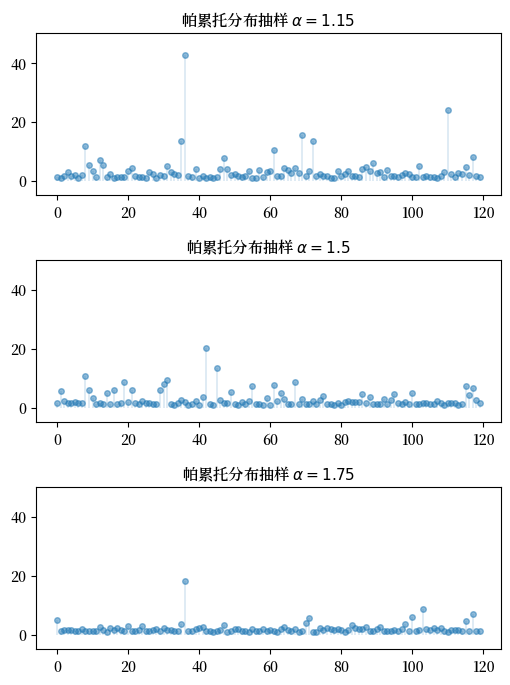

In [28]:
from scipy.stats import pareto

np.random.seed(11)

n = 120
alphas = [1.15, 1.50, 1.75]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))

for (a, ax) in zip(alphas, axes):
    ax.set_ylim((-5, 50))
    data = pareto.rvs(size=n, scale=1, b=a)
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"帕累托分布抽样 $\\alpha = {a}$", fontsize=11)

plt.subplots_adjust(hspace=0.4)

plt.show()

```{solution-end}
```

```{exercise}
:label: ht_ex5

关于企业规模分布应该用帕累托分布还是对数正态分布进行建模的争论一直持续不断（参见例如 {cite}`fujiwara2004pareto`、{cite}`kondo2018us` 或 {cite}`schluter2019size`）。

这听起来很深奥，但对各种经济现象都有实际影响。

为了简单说明这个事实，我们考虑一个拥有100,000家企业的经济体，利率为 `r = 0.05` 并且企业税率为15%。

你的任务是估计未来10年企业税收的现值折现。

因为我们在进行预测，我们需要一个模型。

我们将假设：

1. 企业数量和企业规模分布（以利润计）保持不变，并且
1. 企业规模分布要么是对数正态分布，要么是帕累托分布。

税收的现值折现将通过以下步骤估算：

1. 从企业规模分布生成100,000次企业利润的抽样，
1. 将其乘以税率，并且
1. 通过折现将结果求和以获得现值。

帕累托分布假设采用 {eq}`pareto` 形式，其中 $\bar x = 1$ 且 $\alpha = 1.05$。

（尾指数 $\alpha$ 的值是合理的，鉴于数据 {cite}`gabaix2016power`。）

为了使对数正态选项尽可能类似于帕累托选项，请选择其参数使得两个分布的均值和中位数相同。

注意，对于每个分布，你的税收估算都是随机的，因为它基于有限的抽样。

为了考虑到这一点，对两种分布各产生100次重复（税收收入的估计），并通过以下方式比较两个样本：

* 制作一张将两个样本并排显示的[小提琴图](https://en.wikipedia.org/wiki/Violin_plot)，并且
* 输出两个样本的均值和标准差。

对种子使用 `np.random.seed(1234)`。

你观察到了哪些差异？

（注：解决这个问题的更好方法将是建模企业动态并尝试给定当前分布追踪个别企业。我们将在后续讲座中讨论企业动态。）
```

```{solution-start} ht_ex5
:class: dropdown
```

为了完成这个练习，我们需要选择对数正态分布的参数 $\mu$ 和 $\sigma$，使其匹配Pareto分布的均值和中位数。

这里我们将对数正态分布理解为随机变量 $\exp(\mu + \sigma Z)$，当 $Z$ 是标准正态分布时。

Pareto分布 {eq}`pareto` 的均值和中位数，其中 $\bar x = 1$，分别是

$$
\text{均值} = \frac{\alpha}{\alpha - 1}
\quad \text{和} \quad
\text{中位数} = 2^{1/\alpha}
$$

使用对应的对数正态分布表达式，我们得到以下方程组

$$
\frac{\alpha}{\alpha - 1} = \exp(\mu + \sigma^2/2)
\quad \text{和} \quad
2^{1/\alpha} = \exp(\mu)
$$

我们用 $\alpha = 1.05$ 来解这些方程得到 $\mu$ 和 $\sigma$。

以下是生成两个样本、制作小提琴图并打印两个样本的均值和标准差的代码。

In [29]:
num_firms = 100_000
num_years = 10
tax_rate = 0.15
r = 0.05

β = 1 / (1 + r)    # 折现因子

x_bar = 1.0
α = 1.05

def pareto_rvs(n):
    "使用标准方法生成Pareto抽样。"
    u = np.random.uniform(size=n)
    y = x_bar / (u**(1/α))
    return y

我们来计算对数正态分布的参数：

In [30]:
μ = np.log(2) / α
σ_sq = 2 * (np.log(α/(α - 1)) - np.log(2)/α)
σ = np.sqrt(σ_sq)

这是一个计算特定分布 `dist` 的单一税收估计的函数。

In [31]:
def tax_rev(dist):
    tax_raised = 0
    for t in range(num_years):
        if dist == 'pareto':
            π = pareto_rvs(num_firms)
        else:
            π = np.exp(μ + σ * np.random.randn(num_firms))
        tax_raised += β**t * np.sum(π * tax_rate)
    return tax_raised

现在让我们生成小提琴图。

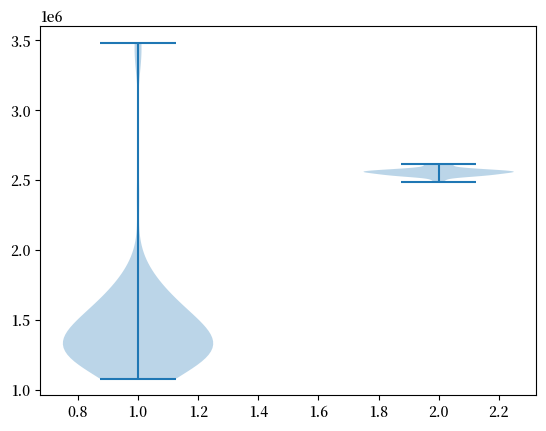

In [32]:
num_reps = 100
np.random.seed(1234)

tax_rev_lognorm = np.empty(num_reps)
tax_rev_pareto = np.empty(num_reps)

for i in range(num_reps):
    tax_rev_pareto[i] = tax_rev('pareto')
    tax_rev_lognorm[i] = tax_rev('lognorm')

fig, ax = plt.subplots()

data = tax_rev_pareto, tax_rev_lognorm

ax.violinplot(data)

plt.show()

最后，我们来生成均值和标准差。

In [33]:
tax_rev_pareto.mean(), tax_rev_pareto.std()

(1458729.0546623734, 406089.3613661567)

In [34]:
tax_rev_lognorm.mean(), tax_rev_lognorm.std()

(2556174.8615230713, 25586.44456513965)

通过查看代码的输出，我们的主要结论是，帕累托分布假设会导致更低的均值和更大的离散度。

```{solution-end}
```

```{exercise}
:label: ht_ex_cauchy

柯西分布的[特征函数](https://en.wikipedia.org/wiki/Characteristic_function_%28probability_theory%29)为

$$
\phi(t) = \mathbb E e^{itX} = \int e^{i t x} f(x) dx = e^{-|t|}
$$ (lln_cch)

证明 $n$ 次独立抽样 $X_1, \ldots, X_n$ 从柯西分布得来的样本均值 $\bar X_n$ 具有与 $X_1$ 相同的特征函数。

（这意味着样本均值永远不会收敛。）

```

```{solution-start} ht_ex_cauchy
:class: dropdown
```

由独立性，样本均值的特征函数变为

$$
\begin{aligned}
    \mathbb E e^{i t \bar X_n }
    & = \mathbb E \exp \left\{ i \frac{t}{n} \sum_{j=1}^n X_j \right\}
    \\
    & = \mathbb E \prod_{j=1}^n \exp \left\{ i \frac{t}{n} X_j \right\}
    \\
    & = \prod_{j=1}^n \mathbb E \exp \left\{ i \frac{t}{n} X_j \right\}
    = [\phi(t/n)]^n
\end{aligned}
$$

根据 {eq}`lln_cch`，这就是 $e^{-|t|}$。

因此，在柯西分布的情况下，样本均值本身具有完全相同的柯西分布，无论 $n$ 是多少！

```{solution-end}
```